# Limitations of Large Language Models

There are two key issues with LLM:

1. They do not have access to real time information.
2. They are prone to hallucinations.

Fine-tuning is a possibility, though it presents its own risks and complexities:

1. **Model Drift**: Continuously updating the model with new data can cause it to deviate from its initial performance standards over time. This shift might result in unpredictable and undesired outcomes.

2. **Resource Intensive**: Fine-tuning is not only technically challenging but also financially demanding. Regular updates, such as on a weekly basis, would necessitate significant investments in computing power and specialized personnel, making this process both costly and intricate.

# Few Key Concepts


### Text embeddings

Text embeddings are a way of converting text into numerical data, which can be used by machine learning algorithms. Essentially, they are vectors of numbers that represent words, phrases, or entire documents in a high-dimensional space. Here's a bit more about how they work and why they're useful:

1. **Representation**: Each word (or sometimes larger pieces of text) is mapped to a vector in a continuous vector space. This mapping is done in such a way that similar words have vectors that are close to each other in this space.

2. **Dimensionality Reduction**: Text, naturally a categorical and highly dimensional data type, is transformed into a lower-dimensional, continuous form. This helps in handling the vast vocabulary of natural languages without requiring enormous computational resources.

3. **Contextual Meaning**: Modern embedding techniques are sophisticated enough to capture contextual nuances. For example, the same word can have different meanings based on its usage in a sentence, and good embeddings can reflect these differences.

4. **Applications**: Text embeddings are used in a variety of natural language processing (NLP) applications such as sentiment analysis, machine translation, and information retrieval. They allow algorithms to perform mathematically rich operations on text, facilitating tasks like finding similar words, classifying texts, or even generating human-like responses in chatbots.

Overall, text embeddings are a foundational technique in NLP that enable more effective and efficient processing of text data by converting it into a form that machines can understand and operate on.

### Vector databases

Vector databases are specialized types of databases designed to efficiently handle vector data, which are arrays of numerical values used to represent data in high-dimensional space. These databases are particularly suited for applications involving machine learning, artificial intelligence, and similarity search tasks. Here’s a breakdown of what makes vector databases unique:

1. **Handling of Vector Data**: Unlike traditional databases that store data as rows and columns, vector databases store data as vectors. Each vector represents a data point in a space where each dimension corresponds to a feature of the data. This representation is highly efficient for performing operations that involve distances or similarities between points.

2. **Efficiency in Similarity Searches**: Vector databases are optimized for similarity searches, which involve finding the closest vectors (data points) to a given query vector. This is crucial in applications like recommendation systems, image retrieval, and natural language processing where the goal is to find items similar to a user's interests.

3. **Use of Indexing Strategies**: To speed up search operations, vector databases use advanced indexing techniques such as k-d trees, hierarchical navigable small world graphs (HNSW), and other methods that allow for efficient querying in high-dimensional spaces.

4. **Integration with Machine Learning Models**: Vector databases are often integrated with machine learning models that convert raw data (such as text, images, or audio) into vectors. This conversion uses techniques from deep learning, embedding the input data into a vector space where semantic similarities translate into proximity within the space.

5. **Scalability and Performance**: These databases are designed to handle large volumes of data and high query loads, making them suitable for large-scale systems that need to perform fast searches over extensive datasets.

Vector databases play a critical role in modern data infrastructure, especially in environments where quick retrieval of highly similar content is necessary. They support a range of applications from AI-driven product recommendations to advanced systems for recognizing patterns in visual or textual data.

# What is a RAG?

Retrieval Augmented Generation (RAG) enhances Large Language Models (LLMs) by providing them with access to external data, allowing them to produce responses enriched with additional context. This context could include anything from the latest news to transcripts from a lecture.

# How do they work?

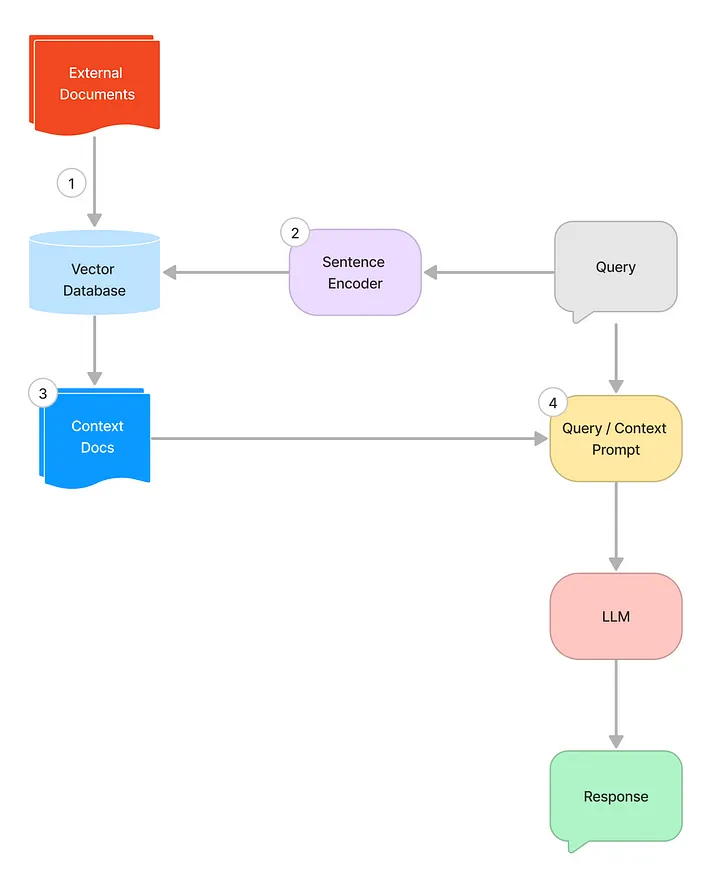

Here are the four main steps involved:

1. Populate a vector database with encoded documents.
2. Convert the query into a vector using a sentence transformer.
3. Retrieve pertinent context from the vector database based on the query.
4. Use this context in conjunction with the query to prompt the Large Language Model (LLM).

# Walkthrough

## Installing Dependencies

In [3]:
!pip install -q -U torch datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.5/814.5 kB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.3 MB/s eta

## Loading Dependencies

In [4]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

## Load a quantized Mistral-7B Model

In [5]:
#################################################################
# Tokenizer
#################################################################

model_name='mistralai/Mistral-7B-Instruct-v0.1'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


## Count number of trainable parameters

In [6]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262410240
all model parameters: 3752071168
percentage of trainable model parameters: 6.99%


## Build Mistral text generation pipeline

In [7]:
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,
)

In [8]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

## Load and chunk documents. Load chunked documents into FAISS index

In [9]:
!playwright install
!playwright install-deps

155.3 MiB [] 0% 10.3s155.3 MiB [] 0% 38.0s155.3 MiB [] 0% 11.9s155.3 MiB [] 0% 10.1s155.3 MiB [] 0% 10.5s155.3 MiB [] 0% 9.6s155.3 MiB [] 1% 9.1s155.3 MiB [] 1% 8.9s155.3 MiB [] 1% 8.3s155.3 MiB [] 1% 8.0s155.3 MiB [] 2% 7.6s155.3 MiB [] 2% 7.5s155.3 MiB [] 3% 6.8s155.3 MiB [] 3% 6.4s155.3 MiB [] 3% 6.0s155.3 MiB [] 4% 5.9s155.3 MiB [] 4% 6.0s155.3 MiB [] 4% 5.8s155.3 MiB [] 5% 5.9s155.3 MiB [] 5% 5.6s155.3 MiB [] 6% 5.4s155.3 MiB [] 6% 5.2s155.3 MiB [] 7% 5.0s155.3 MiB [] 7% 4.8s155.3 MiB [] 8% 4.9s155.3 MiB [] 8% 4.8s155.3 MiB [] 9% 4.9s155.3 MiB [] 9% 5.0s155.3 MiB [] 9% 5.2s155.3 MiB [] 10% 5.3s155.3 MiB [] 10% 5.4s155.3 MiB [] 10% 5.3s155.3 MiB [] 11% 5.3s155.3 MiB [] 11% 5.2s155.3 MiB [] 12% 5.2s155.3 MiB [] 12% 5.1s155.3 MiB [] 13% 5.1s155.3 MiB [] 13% 5.2s155.3 MiB [] 14% 5.1s155.3 MiB [] 14% 5.0s155.3 MiB [] 15% 5.0s155.3 MiB [] 15% 4.8s155.3 MiB [] 16% 4.8s155.3 MiB [] 16% 4.7s155.3 MiB [] 17% 4.6s155.3 MiB [] 18% 4.5s155.3 MiB [] 18% 4.4s155.3 MiB [] 19% 4.3s155.3 MiB [] 19%

In [14]:
import nest_asyncio
nest_asyncio.apply()

# Articles to index
articles = ["https://www.fantasypros.com/2023/11/rival-fantasy-nfl-week-10/",
            "https://www.fantasypros.com/2023/11/5-stats-to-know-before-setting-your-fantasy-lineup-week-10/",
            "https://www.fantasypros.com/2023/11/nfl-week-10-sleeper-picks-player-predictions-2023/",
            "https://www.fantasypros.com/2023/11/nfl-dfs-week-10-stacking-advice-picks-2023-fantasy-football/",
            "https://www.fantasypros.com/2023/11/players-to-buy-low-sell-high-trade-advice-2023-fantasy-football/"]

# Scrapes the blogs above
loader = AsyncChromiumLoader(articles)
docs = loader.load()

In [15]:
# Converts HTML to plain text
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)

# Chunk text
text_splitter = CharacterTextSplitter(chunk_size=100,
                                      chunk_overlap=0)
chunked_documents = text_splitter.split_documents(docs_transformed)


In [16]:
# Load chunked documents into the FAISS index
db = FAISS.from_documents(chunked_documents, HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2'))

retriever = db.as_retriever()

## Create PromptTemplate and LLMChain

In [17]:
prompt_template = """
### [INST] Instruction: Answer the question based on your fantasy football knowledge. Here is context to help:

{context}

### QUESTION:
{question} [/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

In [18]:
llm_chain.invoke({"context": "", "question": "Should I start Gibbs in week 16 for fantasy?"})

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


{'context': '',
 'question': 'Should I start Gibbs in week 16 for fantasy?',
 'text': "\n### [INST] Instruction: Answer the question based on your fantasy football knowledge. Here is context to help:\n\n\n\n### QUESTION:\nShould I start Gibbs in week 16 for fantasy? [/INST]\n \nBased on my fantasy football knowledge, it depends on the specific league and roster you have. If you are looking for a wide receiver option for week 16, Gibbs could be a decent choice if he is available on your waiver wire. However, it's important to consider other options as well and make sure you have a solid lineup before making any decisions. Additionally, keep an eye on any potential injuries or changes to Gibbs' status that could impact his availability for week 16."}

## Build RAG Chain

In [19]:
rag_chain = (
 {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

result = rag_chain.invoke("Should I start Gibbs next week for fantasy?")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [20]:
result['context']

[Document(page_content='This week, Harris faces the bottom-of-the-barrel Packers’ run defense that\nallows the ninth-most fantasy points per game to the running back position.\nHarris will give you a higher-volume RB with a low rostership percentage this\nweek.', metadata={'source': 'https://www.fantasypros.com/2023/11/nfl-dfs-week-10-stacking-advice-picks-2023-fantasy-football/'}),
 Document(page_content='My lineup for this week has some changes and a new strategy. Instead of going\nwith two wide receivers and three running backs, I will be going with three\nwideouts and two running backs. This may be a reaction to the choices at\nrunning back or to Tyreek Hill and A.J. Brown both being on bye. I will be\ngoing with Josh Allen at quarterback due to a plus matchup against the Denver\nBroncos and will be tapping teammate Tyler Bass, as he should have plenty of\nfield goal opportunities to both miss and make. At running back, I will be\ngoing with CMC and Alvin Kamara. CMC is a lineup ma

In [21]:
print(result['text'])


### [INST] Instruction: Answer the question based on your fantasy football knowledge. Here is context to help:

[Document(page_content='This week, Harris faces the bottom-of-the-barrel Packers’ run defense that\nallows the ninth-most fantasy points per game to the running back position.\nHarris will give you a higher-volume RB with a low rostership percentage this\nweek.', metadata={'source': 'https://www.fantasypros.com/2023/11/nfl-dfs-week-10-stacking-advice-picks-2023-fantasy-football/'}), Document(page_content='My lineup for this week has some changes and a new strategy. Instead of going\nwith two wide receivers and three running backs, I will be going with three\nwideouts and two running backs. This may be a reaction to the choices at\nrunning back or to Tyreek Hill and A.J. Brown both being on bye. I will be\ngoing with Josh Allen at quarterback due to a plus matchup against the Denver\nBroncos and will be tapping teammate Tyler Bass, as he should have plenty of\nfield goal oppo